## 간단한 네트워크 분석 함수 

### 구현 기능 

- 특허별로 weighted degree centrality, closenss centrality, betweenness centrality 분석하여 엑셀파일에 저장
- 하나의 특허에 대한 ego network 도출하여 그림 파일 저장
- 모든 특허에 대한 network 도출하여 그림 파일 저장
    - 너무 복잡해져서, weighted degree centrality 기준 상위 노드 30개, edge 상위 50개만 그림 
- 단, 이 모든 코드는 파이썬3에서 문제없이 돌아감. 
    - 파이썬 2에서는 라이브러리의 메소드들이 다를 수 있어 추후 확인이 필요함

### 사용한 라이브러리 
- `networkx`: 파이썬 네트워크 분석 라이브러리
- `pandas`: 엑셀 파일 read, write를 위한 라이브러리
- `numpy`: 꼭 필요하지는 않지만, 종종 씀
- `matplotlib`: 그림 그리기 위해 필요한 라이브러리

- 모두 `pip install`로 설치할 것 

In [528]:
import networkx as nx
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

- 함수를 세 개 구현했는데, 제일 마지막에 있는, make_centrality_excel 함수만 사용하면 됨
    - 다른 함수는 모두 이 함수에 내부에서 사용하는 함수 

In [530]:
def return_weighted_degree_centrality(G, normalized=False):
    centrality={}
    weighted_sum = [ edge[2]['weight'] for edge in G.edges(data=True) ]
    weighted_sum = sum(weighted_sum)
    for node1 in G.nodes():
        weighted_degree = 0
        if normalized==False:
            for node2 in G.nodes():
                try:
                    weighted_degree+=G[node1][node2]['weight']
                except:
                    continue
        else:
            for node2 in G.nodes():
                try:
                    weighted_degree+=G[node1][node2]['weight']/weighted_sum
                except:
                    continue
        centrality[node1]=weighted_degree
    return centrality

In [531]:
def return_centrality_df(G):
    weighted_degree_centrality = return_weighted_degree_centrality(G, normalized=True)
    betweenness_centrality = nx.betweenness_centrality(G, weight='weight', normalized=True)
    # weight, betweenness는 weight를 고려하기 때문에, 기존 테이블에서 중요한 edge를 그대로 넣어주는게 맞음
    # 그러나 closenss의 경우는 distance를 고려하기 때문에, 역수를 넣어 계산하는 것이 필요함. 
    newG = nx.Graph()
    distance_edge_lst = [(edge[0], edge[1], 1.0/edge[2]['weight']) for edge in G.edges(data=True)]
    newG.add_weighted_edges_from(distance_edge_lst)
    
    closeness_centrality = nx.closeness_centrality(newG, distance='weight', normalized=True)

    weighted_deg_df = pd.DataFrame(list((k, weighted_degree_centrality[k]) for k in weighted_degree_centrality.keys()), columns=['node', 'weighted_degree_cen'])
    clo_df = pd.DataFrame(list((k, closeness_centrality[k]) for k in closeness_centrality.keys()), columns=['node', 'close_cen'])
    bet_df = pd.DataFrame(list((k, betweenness_centrality[k]) for k in betweenness_centrality.keys()), columns=['node', 'bet_cen'])

    weighted_deg_df = weighted_deg_df.sort_values('weighted_degree_cen', ascending=False)
    clo_df = clo_df.sort_values('close_cen', ascending=False)
    bet_df = bet_df.sort_values('bet_cen', ascending=False)

    # join two dataframe 
    centrality_df = clo_df.merge(right=bet_df, left_on="node", right_on="node")
    centrality_df = centrality_df.merge(right=weighted_deg_df, left_on="node", right_on="node")
    return centrality_df

In [ ]:
def make_centrality_excel(input_excel_name, output_excel_name):
    # distance와 weight가 같은가? 
    df1 = pd.read_excel('test.xlsx') # 다른 엑셀 파일에서도 문제없는지 확인 필요 
    dict_df1 = dict(df1)
    edge_lst = [(k1, k2, dict_df1[k1][k2]) for k1 in dict_df1.keys() for k2 in dict_df1.keys()]
    # 역수로 변환하지 않고, 일단 그대로 둠.
    # betweenness centrality는 weight, closeness centrality는 distance
    G = nx.Graph()
    G.add_weighted_edges_from(edge_lst)
    for edge in G.edges():
        if edge[0]==edge[1]:
            G.remove_edge(edge[0], edge[1])
    
    df = return_centrality_df(G)
    # write excel 
    writer = pd.ExcelWriter(output_excel_name)
    df.to_excel(writer, "sheet1")
    writer.save()
    
make_centrality_excel('test.xlsx', 'output2.xlsx')

## input excel file

- input excel file 은 아래 형식처럼 matrix의 형태로 저장되어 있어야 함
    - 그래야 해당함수에서 문제없이 긁어올 수 있음
    - 첫번째 칼럼, 첫번째 로우는 노드들의 이름, 나머지는 모두 노드간의 closensess
        - 역수를 취하지 않은 closeness를 그대로 넣어야 함

    - centrality 계산 시에, closeness centrality의 경우, distance를 고려하기 때문에, 해당 경우에는 값에 역수를 취해야 하지만, 다른 경우에는 weight로 고려되기 때문에 역수가 아닌 원래 값을 그대로 넣어야 함. 
        - 따라서 역수를 취하지 않은 closeness를 그대로 넣어야 함

In [543]:
pd.read_excel("test.xlsx")

,n0,n1,n10,n11,n12,n13,n14,n15,n16,n17,...,n90,n91,n92,n93,n94,n95,n96,n97,n98,n99
n0,0.908406,0.932916,0.235506,0.000154,0.572478,0.580960,0.798061,0.033167,0.080147,0.289793,...,0.967833,0.991617,0.090811,0.777357,0.393032,0.398655,0.230338,0.010841,0.200335,0.257472
n1,0.695810,0.292426,0.177653,0.595567,0.709129,0.820720,0.049412,0.560791,0.741061,0.422150,...,0.330642,0.129265,0.216806,0.546589,0.120786,0.928567,0.601099,0.066583,0.301343,0.136920
n10,0.296311,0.828910,0.271187,0.277459,0.416129,0.651801,0.046252,0.140151,0.948404,0.487438,...,0.981272,0.279712,0.291611,0.738282,0.211550,0.086894,0.554521,0.185120,0.019591,0.423164
n11,0.303424,0.110439,0.854689,0.382156,0.846344,0.355934,0.776418,0.995609,0.761952,0.345112,...,0.983979,0.100396,0.491610,0.586519,0.837381,0.581745,0.815442,0.272833,0.663507,0.384085
n12,0.765825,0.734925,0.168366,0.402646,0.145199,0.729554,0.197089,0.658157,0.248303,0.543938,...,0.574727,0.728787,0.922691,0.190547,0.701428,0.824148,0.212831,0.567276,0.087889,0.550247
n13,0.228878,0.584932,0.466344,0.811443,0.858558,0.371189,0.145293,0.320293,0.420121,0.068763,...,0.604363,0.970022,0.106666,0.516100,0.652543,0.493083,0.198167,0.865022,0.937134,0.439413
n14,0.909087,0.975211,0.640383,0.992433,0.083270,0.860207,0.879860,0.159521,0.316405,0.665682,...,0.589555,0.161764,0.169058,0.138416,0.158009,0.250264,0.469943,0.006896,0.722335,0.829329
n15,0.587520,0.050451,0.053849,0.643198,0.476897,0.322572,0.069237,0.971566,0.617706,0.593224,...,0.714814,0.716653,0.268387,0.612858,0.791434,0.938071,0.384712,0.063858,0.906238,0.396004
n16,0.203624,0.634302,0.109817,0.757273,0.837955,0.785191,0.813828,0.195654,0.701316,0.160826,...,0.071209,0.491612,0.625728,0.026588,0.943796,0.565844,0.724270,0.206437,0.594177,0.366658
n17,0.185868,0.620718,0.879670,0.143169,0.508130,0.173657,0.917779,0.835334,0.057524,0.084406,...,0.318420,0.365926,0.315654,0.292683,0.499980,0.244628,0.771369,0.811861,0.640787,0.115643


## 특정 노드에 대한 ego-network를 그려주는 함수 

- 순서대로, input_excel_file, 내가 보고 싶은 특정 노드(혹은 특허), 최종 산출 파일 그림 을 넣어준다. 
    - node의 크기는 해당 node의 weighted degree centrality, 
    - edge의 굵기는 node간의 closeness 
- 노드가 많으면 복잡해 보여서, 여기서는 상위 10개의 노드만 그려준다 

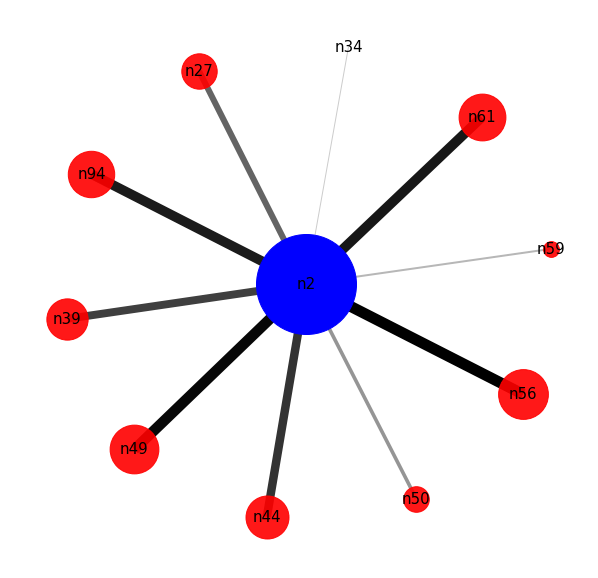

In [544]:
def draw_ego_network(input_excel_file, target_node_name, output_figure_name):
    """
    target_node와 강하게 연결된 상위 10개 노드에 대해서만 그려준다
    """
    df1 = pd.read_excel(input_excel_file) # 다른 엑셀 파일에서도 문제없는지 확인 필요
    edge_lst = df1.loc()[target_node_name]
    edge_lst = [(target_node_name, n, edge_lst[n]) for n in edge_lst.index]

    G = nx.Graph()
    G.add_weighted_edges_from(edge_lst)
    for edge in G.edges():
        if edge[0]==edge[1]:
            G.remove_edge(edge[0], edge[1])
    # weighted_degree centrality 기준 상위 10개 노드 필터링 
    filtered_nodes = return_weighted_degree_centrality(G)
    filtered_nodes = [(k, v) for k, v in filtered_nodes.items()]
    filtered_nodes = sorted(filtered_nodes, key=lambda x: x[1], reverse=True)[:11]
    filtered_nodes = [node[0] for node in filtered_nodes]
    
    # 네트워크에서 상위 10개 노드 + 타겟노드 만 남기고 모두 삭제 
    for node in G.nodes():
        if node not in filtered_nodes:
            G.remove_node(node)
    # 그림 그리기 
    plt.figure(figsize=(10,10))
    pos = nx.spring_layout(G)
    weight_lst = return_weighted_degree_centrality(G)
    weight_dict = {n:weight_lst[n] for n in filtered_nodes}
    min_weight = min(weight_dict.values())
    max_weight = max(weight_dict.values())
        
    for node in G.nodes():
        if node==target_node_name:
            nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=10000, node_color='blue')
        else:
            node_size = (weight_dict[node] - min_weight)/(max_weight-min_weight)
            nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=node_size*200000, alpha=0.9)
    nx.draw_networkx_labels(G, pos, font_size=15)
    # 노드 간의 관계를 고려하여, 중요한 관계의 edge를 굵게 처리
    # 다만, 네트워크 분석을 위해서 기존 closeness를 역수로 변환하였는데(중요한 관계일 수록, distance가 작도록)
    # 이를 다시 역수로 변환하여, closeness
    weight_lst = [edge[2]['weight'] for edge in G.edges(data=True)]
    max_weight = max(weight_lst)
    min_weight = min(weight_lst)
    
    for edge in G.edges(data=True):
        width = (edge[2]['weight']-min_weight)/(max_weight-min_weight)
        alpha = width*0.8+0.2
        width = width*10+1
        nx.draw_networkx_edges(G, pos,edgelist=[edge], width=width, alpha=alpha)
        
    plt.axis('off')
    plt.savefig(output_figure_name)
    plt.show()
    
draw_ego_network('test.xlsx', 'n2', 'n1_output.png')

## 모든 노드에 대한 네트워크를 그려주는 함수 

- 순서대로, input_excel_file, 최종 산출 그림 파일 명을 넣어준다. 
    - node의 크기는 해당 node의 weighted degree centrality, 
    - edge의 굵기는 node간의 closeness 
- 노드가 많으면 복잡해 보여서, 여기서는 상위 30개의 노드만 그려준다 
- edge가 많아도 복잡해 보여서, 여기서는 상위 50개의 키워드만 보여준다. 

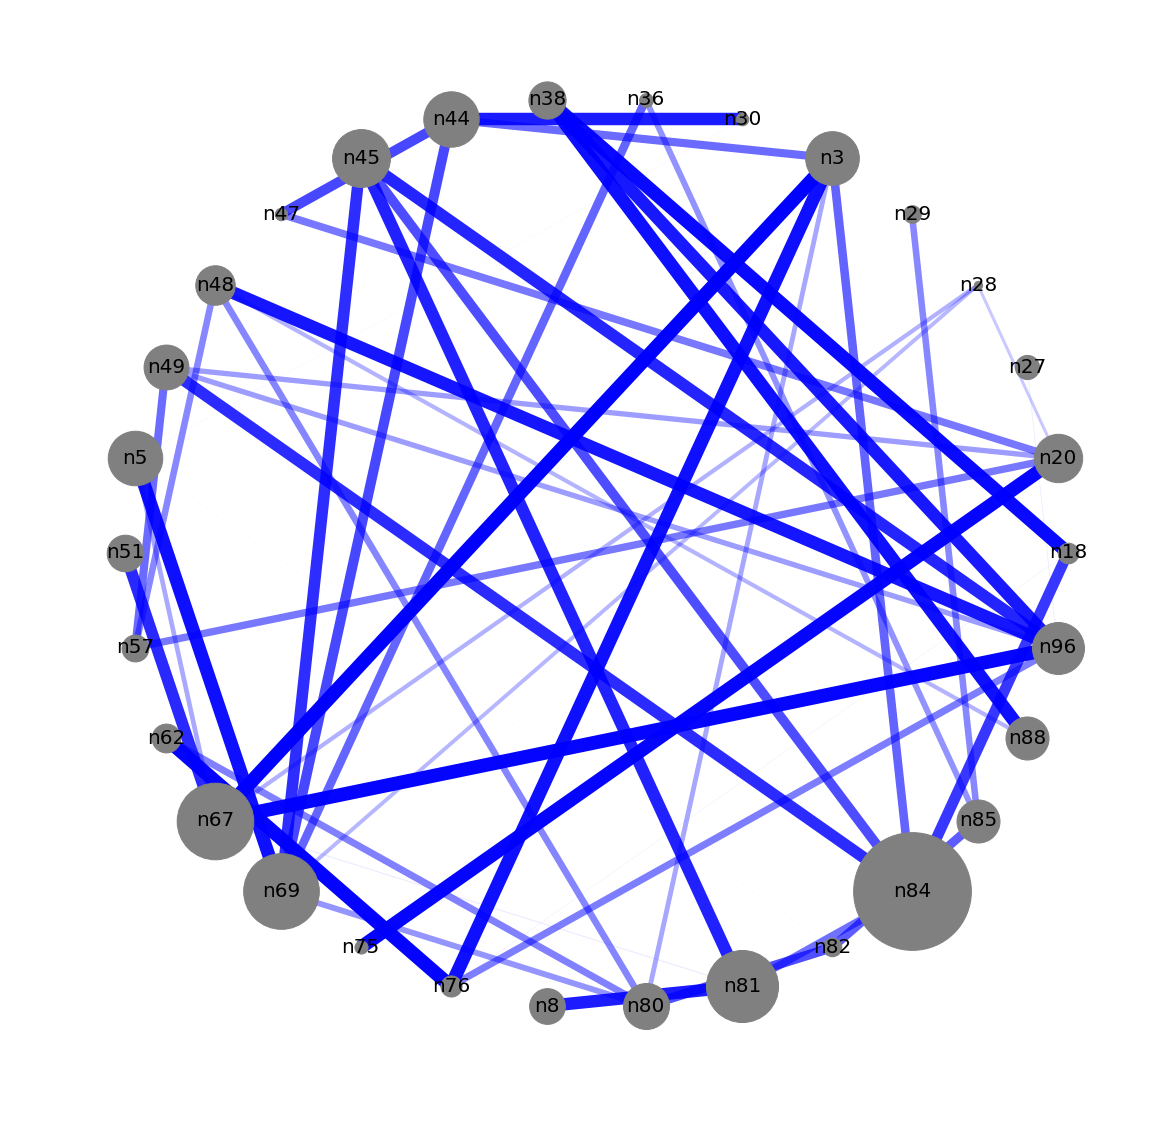

In [545]:
def draw_whole_network(input_excel_file, output_figure_name):
    # node size, edge width 등을 exponential 하게 그려주는게 좋을 것 같은데
    """
    weighted degree centrality 기준 상위 30개 노드만 그려준다. 
    """
    df1 = pd.read_excel('test.xlsx') # 다른 엑셀 파일에서도 문제없는지 확인 필요 
    dict_df1 = dict(df1)
    edge_lst = [(k1, k2, dict_df1[k1][k2]) for k1 in dict_df1.keys() for k2 in dict_df1.keys()]

    G = nx.Graph()
    G.add_weighted_edges_from(edge_lst)
    for edge in G.edges():
        if edge[0]==edge[1]:
            G.remove_edge(edge[0], edge[1])
    # weighted_degree centrality 기준 상위 30개 노드 필터링 
    filtered_nodes = return_weighted_degree_centrality(G)
    filtered_nodes = [(k, v) for k, v in filtered_nodes.items()]
    filtered_nodes = sorted(filtered_nodes, key=lambda x: x[1], reverse=True)[:30]
    filtered_nodes = [node[0] for node in filtered_nodes]
    
    # 네트워크에서 상위 10개 노드 + 타겟노드 만 남기고 모두 삭제 
    for node in G.nodes():
        if node not in filtered_nodes:
            G.remove_node(node)
    # 그림 그리기 
    plt.figure(figsize=(20,20))
    #pos = nx.spring_layout(G)
    #pos = nx.spectral_layout(G)
    pos = nx.shell_layout(G)
    
    node_size_lst = return_weighted_degree_centrality(G, normalized=True)
    min_node_size = min(node_size_lst.values())
    max_node_size = max(node_size_lst.values())
    for k in node_size_lst.keys():
        node_size_lst[k] = (node_size_lst[k] - min_node_size)/(max_node_size - min_node_size)
    for node in G.nodes():
        # node의 중요도에 따라서, 크기를 다르게
        #alpha = node_size_lst[node]/4*3+0.25
        node_size = (200**(node_size_lst[node]+0.8))
        nx.draw_networkx_nodes(G, pos, nodelist=[node], node_size=node_size, node_color='gray')
    nx.draw_networkx_labels(G, pos, font_size=20)
    # 노드 간의 관계를 고려하여, 중요한 관계의 edge를 굵게 처리
    # 다만, 네트워크 분석을 위해서 기존 closeness를 역수로 변환하였는데(중요한 관계일 수록, distance가 작도록)
    # 이를 다시 역수로 변환하여, closeness
    weight_lst = [edge[2]['weight'] for edge in G.edges(data=True)]
    max_weight = max(weight_lst)
    min_weight = min(weight_lst)
    # 표준화했을 때, 0.9를 넘는 edge만 남긴다. 
    weight_lst = [(weight - min_weight)/(max_weight-min_weight) for weight in weight_lst]
    edge_weight_threshold = sorted(weight_lst, reverse=True)[50]
    # 상위 50개의 엣지만 고름, 50개 넘어가면 보기힘듬 
    max_weight = max(weight_lst)
    min_weight = edge_weight_threshold
    weight_lst = list(weight_lst)
    
    edges = G.edges(data=True)
    for i in range(0, len(edges)):
        if weight_lst[i]>edge_weight_threshold:
            std_weight = (edges[i][2]['weight']-min_weight)/(max_weight-min_weight)
            width = std_weight *14+0.03
            alpha = std_weight
            nx.draw_networkx_edges(G, pos,edgelist=[edges[i]], width=width, alpha=alpha, edge_color='blue')
            # cmap=plt.get_cmap(name)
    plt.axis('off')
    plt.savefig(output_figure_name)
    plt.show()
    
draw_whole_network('test.xlsx','whole_output.png')